In [ ]:
#Nous importons nos bibiliothèques utiles
import os
import random
from scipy import spatial
from tqdm import tqdm
import time
import seaborn as sn
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Nous allons convertir nos images en niveau de gris
def convertToGray(images):
    grayImages = [0] * images.shape[0]
    for i, img in enumerate(images):
        grayImages[i] = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return np.array(grayImages)


In [ ]:
# Recherche des index des K plus grande valeur de matches sous forme de score
def getMaxIndex(tab, d_match, k, trainLabels):
    countScores = [0] * k
    labels = [0] * k
    dm = [0] * k
    index_s = [0] * k

    for i in range(k):
        m = max(tab)
        index = tab.index(m)
        countScores[i] = round(m, 2)
        labels[i] = trainLabels[index]
        dm[i] = d_match[index]
        index_s[i] = index
        tab[index] = -1

    return np.array(list(zip(labels, countScores, dm, index_s)))

In [ ]:
# Fonction de prédiction de l'image à partir des descripteurs
def descriptorsPredictions(desc, descriptors_train, trainLabels, threshold, k):
    sc, d_match = nbrMatch(descriptors_train, desc, threshold)
    p = getMaxIndex(sc, d_match, k, trainLabels)
    (objects, qte) = np.unique([i[0] for i in p], return_counts=True)
    arg = list(zip(objects, qte))
    arg = sorted(arg, key=lambda item: item[1], reverse=True)

    # We search for the predicted object with the highest score
    obj = arg[0][0]
    p = sorted(p, key=lambda item: item[1], reverse=True)
    # We return the first found
    for find in p:
        if obj == find[0]:
            return find


In [ ]:
#Téléchargement du dataset
import gdown 
url = "https://drive.google.com/uc?id=1rwVyzK2oJg1iEd84wQ08geXwY6OzprwN"
out = "coil-100.zip"
gdown.download(url, out, quiet=False)

!unzip coil-100.zip

In [ ]:
#Nous chargeons nos images
imagesPath = 'coil-100/'
imagesList = [ f for f in os.listdir(imagesPath) if os.path.isfile(os.path.join(imagesPath,f)) ]

imagesObj = []
labeslObj = []

for img in imagesList:
  #Nous devons nous assurer que le fichier traité est une image
    if img.split('.')[1] == 'png':
        image = cv2.imread(os.path.join(imagesPath, img))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        imagesObj.append(image)
        #Pour calculer le nombre de classes que nous avons
        labeslObj.append(img.split('__')[0])

#Nous allons transformer nos images en des arrays numpy    
imagesObj = np.array(imagesObj)
labeslObj = np.array(labeslObj)
print('{} images chargées avec succès'.format(imagesObj.shape[0]))

7200 images chargées avec succès


In [ ]:
#Affichage de quelques labels
print(labeslObj)

['obj79' 'obj5' 'obj45' ... 'obj28' 'obj31' 'obj94']


In [ ]:
#Fonction pour l'affichage des resultats
def showResults(figsize, imagesArray, size):
  plt.figure(figsize=figsize)
  for k, i in np.ndenumerate(np.random.randint(imagesArray.shape[0], size=size)):
      ax = plt.subplot(4, 4, k[0] + 1)
      plt.imshow(imagesArray[i], cmap='gray')
      plt.title('Image N° {}'.format(i))
      plt.axis("off")


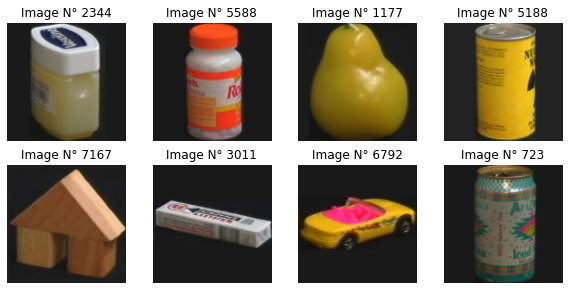

In [ ]:
showResults((10,10), imagesObj, 8) 

In [ ]:
print("Nombre total de classes dans notre dataset : ", len(np.unique(labeslObj)))

Nombre total de classes dans notre dataset :  100


In [ ]:
#Utilisation de la fonction train_test_split de  learn pour avoir nos données d'entrainement et de test 
#avec le random_state=42 pour avoir les memes données divisées à chaque éxécution
trainImages, testImages, trainLabels, testLabels = train_test_split(imagesObj, labeslObj, test_size=0.3, random_state=42)

In [ ]:
grayTrainImages = convertToGray(trainImages)

grayTestImages = convertToGray(testImages)

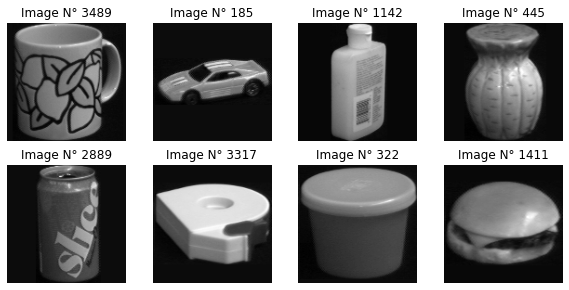

In [ ]:
showResults((10,10), grayTrainImages, 8)

In [ ]:
# Fonction pour calculer les descripteurs locaux pour chaque image
def calculateDescriptors(images, grayImages):
    sift = cv2.xfeatures2d.SIFT_create()
    descriptors = [0] * images.shape[0]
    keypoints = [0] * images.shape[0]
    keypointsList = [0] * images.shape[0]
    
    for i, img in enumerate(grayImages):
        kp, des = sift.detectAndCompute(img, None)
        descriptors[i] = des
        keypoints[i] = cv2.drawKeypoints(img, kp, images[i].copy(), flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        keypointsList[i] = kp
        
    return np.array(descriptors), np.array(keypoints), np.array(keypointsList)

In [ ]:
trainDescriptors, trainKPImages, trainKP = calculateDescriptors(trainImages, grayTrainImages)

testDescriptors, testKPImages, testKP = calculateDescriptors(testImages, grayTestImages)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


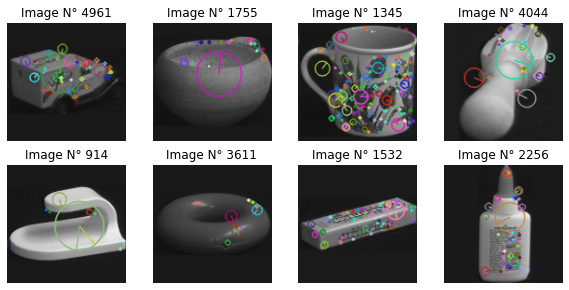

In [ ]:
showResults((10,10), np.array(trainKPImages), 8)

In [ ]:
#Nous allons enregistrer nos descripteurs dans des fichiers
np.save('descriptors.npy', trainDescriptors)
np.save('labels.npy', trainLabels)

In [ ]:
#Relecture des fichiers enregistrés si l'on veut utiliser pour ne pas reprendre depuis le début
oldDescriptors = np.load('descriptors.npy', allow_pickle=True)
oldLabels = np.load('labels.npy', allow_pickle=True)

In [ ]:
#fonction de verification du matching
def verifMatch(trainVectors, testVectors, THRESHOLD):
    keyTrainToTest = []
    
    if testVectors is not None:
        result = [None] * testVectors.shape[0]
        correspondance = 0

        tree = spatial.KDTree(trainVectors)

        euclDistance, index = tree.query(testVectors, p=2, k=2)

        for k, (dist, ind) in enumerate(zip(euclDistance, index)):

            ratio = dist[0] / dist[1]
            if ratio < THRESHOLD:
                tree_2 = spatial.KDTree(testVectors)

                euclDistance_2, index_2 = tree_2.query(trainVectors[ind[0]], p=2, k=2)

                ratio_2 = euclDistance_2[0] / euclDistance_2[1]
                if ratio_2 < THRESHOLD and index_2[0] == k:
                     
                    result[k] = trainVectors[ind[0]]
                    keyTrainToTest.append(cv2.DMatch(ind[0], index_2[0], euclDistance_2[0]))
                    correspondance += 1
                else:
                    result[k] = None
            else:
                result[k] = None

        return correspondance/trainVectors.shape[0], result, keyTrainToTest
    else:
        return 0, [], keyTrainToTest

Calcul du nombre de matches par classes sur les images d'entrainement

In [ ]:
#Fonction de calcul de nombre de match
def nbrMatch(trainDesc, testDesc, THRESHOLD):
    result = []
    d_match = []

    for i, img in enumerate(trainDesc):
        dm = []
        if isinstance(img, type(None)):
            score = 0
        else:
            score, _, dm = verifMatch(img, testDesc, THRESHOLD)
        result.append(score)
        d_match.append(dm)

    return result, d_match

In [ ]:
myScoreMatch = nbrMatch(trainDescriptors, testDescriptors[33], 0.6)

In [ ]:
#classement par ordre décroissant des scores
print(np.sort(myScoreMatch[0])[::-1])

[0.4        0.3125     0.28571429 ... 0.         0.         0.        ]


In [ ]:
predict = getMaxIndex(myScoreMatch[0], myScoreMatch[1], 5, trainLabels)

print(predict)

[['obj86' 0.4
  list([< cv2.DMatch 0x7f15b614a7b0>, < cv2.DMatch 0x7f15b614a7f0>, < cv2.DMatch 0x7f15b614a810>, < cv2.DMatch 0x7f15b614a830>, < cv2.DMatch 0x7f15b614a850>, < cv2.DMatch 0x7f15b614a7d0>, < cv2.DMatch 0x7f15b614a870>, < cv2.DMatch 0x7f15b614a890>, < cv2.DMatch 0x7f15b614a8b0>, < cv2.DMatch 0x7f15b614a8d0>, < cv2.DMatch 0x7f15b614a8f0>, < cv2.DMatch 0x7f15b614a910>, < cv2.DMatch 0x7f15b614a930>, < cv2.DMatch 0x7f15b614a950>, < cv2.DMatch 0x7f15b614a970>, < cv2.DMatch 0x7f15b614a990>])
  445]
 ['obj86' 0.31
  list([< cv2.DMatch 0x7f15b60474d0>, < cv2.DMatch 0x7f15b6047510>, < cv2.DMatch 0x7f15b6047530>, < cv2.DMatch 0x7f15b6047550>, < cv2.DMatch 0x7f15b6047570>, < cv2.DMatch 0x7f15b6047470>, < cv2.DMatch 0x7f15b6047590>, < cv2.DMatch 0x7f15b60475b0>, < cv2.DMatch 0x7f15b60475d0>, < cv2.DMatch 0x7f15b60475f0>])
  2607]
 ['obj86' 0.29
  list([< cv2.DMatch 0x7f15b6022730>, < cv2.DMatch 0x7f15b6022770>, < cv2.DMatch 0x7f15b6022790>, < cv2.DMatch 0x7f15b60227b0>, < cv2.DMatch 0x

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
#Nous affichons quelques résultats
illustration = []
for i in range(len(testImages[:10])):
  result = descriptorsPredictions(testDescriptors[i], trainDescriptors, trainLabels, 0.6, 5)
  other = cv2.drawMatches(trainImages[result[3]], trainKP[result[3]], testImages[i], testKP[i], result[2], None)
  illustration.append(other)
  
  #plt.imshow(illustration)

illustration = np.array(illustration)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


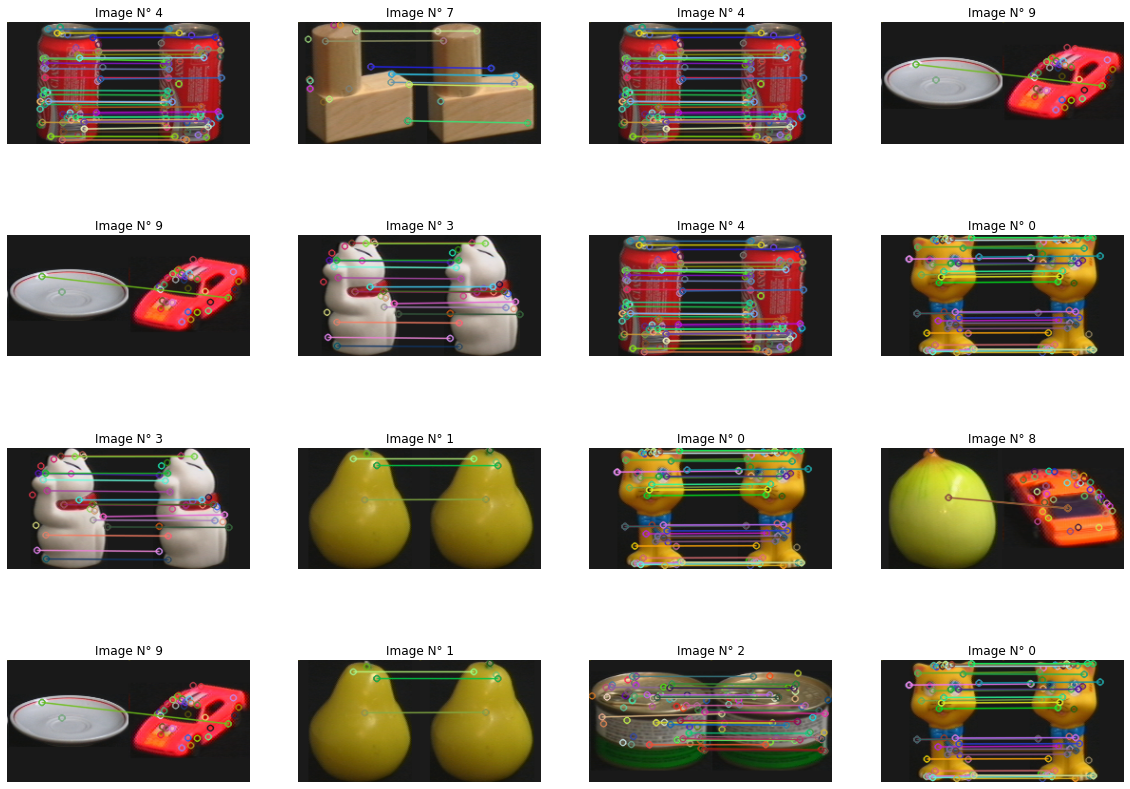

In [ ]:
showResults((20,15), illustration, 16)

In [ ]:
# Evaluation

def evaluation(THRESHOLD, K = 5):
    predictions = [0] * testLabels.shape[0]
    with tqdm(total=testLabels.shape[0], desc="Prediction", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
        for i, des_test in enumerate(testDescriptors):
            predictions[i] = descriptorsPredictions(des_test, trainDescriptors, trainLabels, THRESHOLD, K)[0]
            pbar.update(1)
        
    return predictions

In [ ]:
#évaluation sur toutes les images de train
predictionsLabels = evaluation(0.7, 5)
# Calcul du score
sum(predictionsLabels == testLabels) / testLabels.shape[0]

Prediction:   0%|           [ time left: ? ]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Prediction:  75%|███████▍   [ time left: 23:10 ]

In [ ]:
#A sauvegarder après le premier entrainement pour ne plus reprendre cela
predictLabelsToSave = np.array(predictionsLabels)
np.save('/content/drive/MyDrive/predictedLabels.npy', predictLabelsToSave)
np.save('/content/drive/MyDrive/testLabels.npy', testLabels)

In [ ]:
#Téléchargement des fichiers enregistrés lors de l'évaluation pour ne pas perdre le temps
url = "https://drive.google.com/uc?id=1GNkKb57lQijr9FNqE42tsznUV4YmTFZd"
url2 = "https://drive.google.com/uc?id=1--wRY7z_d5u0cQn-qp0PER7wkGcZdDZy"
gdown.download(url, 'test.npy', quiet=False)
gdown.download(url2, 'predit.npy', quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1GNkKb57lQijr9FNqE42tsznUV4YmTFZd
To: /content/test.npy
100%|██████████| 34.7k/34.7k [00:00<00:00, 32.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--wRY7z_d5u0cQn-qp0PER7wkGcZdDZy
To: /content/predit.npy
100%|██████████| 34.7k/34.7k [00:00<00:00, 32.8MB/s]


'predit.npy'

In [ ]:
testLabelsFromDrive = np.load('test.npy', allow_pickle=True)
predictionLabelsFromDrive = np.load('predit.npy', allow_pickle=True)

In [ ]:
#Matrice de confusion
confusionMatrix = confusion_matrix(testLabelsFromDrive, np.array(predictionLabelsFromDrive))

df_cm = pd.DataFrame(confusionMatrix, index = [i for i in np.unique(testLabelsFromDrive)],
              columns = [i for i in np.unique(testLabelsFromDrive)])

plt.figure(figsize = (30,30))
plt.title('Confusion Matrix', fontsize = 20)
sn.heatmap(df_cm, annot=True, cmap="gray_r", linewidths=.5)
plt.xlabel('Actual', fontsize = 15) 
plt.ylabel('Predicted', fontsize = 15) 
plt.show()

In [ ]:
print(classification_report(testLabelsFromDrive, predictionLabelsFromDrive))

              precision    recall  f1-score   support

        obj1       0.69      1.00      0.82         9
       obj10       0.95      1.00      0.98        21
      obj100       0.82      1.00      0.90         9
       obj11       0.46      1.00      0.63         6
       obj12       0.83      0.71      0.77        14
       obj13       0.95      1.00      0.98        20
       obj14       1.00      1.00      1.00        19
       obj15       0.71      1.00      0.83        12
       obj16       1.00      1.00      1.00        13
       obj17       1.00      1.00      1.00        16
       obj18       1.00      1.00      1.00        13
       obj19       0.86      1.00      0.92         6
        obj2       1.00      0.20      0.34        49
       obj20       1.00      1.00      1.00        16
       obj21       0.69      1.00      0.82         9
       obj22       0.82      1.00      0.90        14
       obj23       0.90      0.90      0.90        10
       obj24       0.71    